## Estimate changed area based on two annual crop masks

**Author**: Hannah Kerner (hkerner@umd.edu)

**Description**: This notebook performs the following steps:
1. Clips annual crop masks to a regional boundary (admin1 shape or user-defined bounding box)
2. Converts crop prediction maps to binarized masks
3. Creates 4-class change map based on crop masks from two years 
4. Creates random stratified reference sample from change map strata following best practices
5. Computes the confusion matrix between the labeled reference sample and the change map
6. Calculates the change class areas and accuracy estimates based on [Olofsson et al., 2014](https://www.sciencedirect.com/science/article/abs/pii/S0034425714000704)

To be added in the future:
- Code for sub-regional estimates (subsetting the reference sample according to admin2 bounds, e.g.), probably as a separate notebook

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
import cartopy.io.shapereader as shpreader
from shapely.geometry import box
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## 1. Clip annual crop masks to a regional boundary (admin1 shape or user-defined bounding box)

Before you begin, make sure you have taken the following steps:
1. Make sure your rasters are projected using the local UTM zone (EPSG:326XX where XX is the 2-digit UTM zone). The easiest way to reproject a raster is using gdalwarp on the command line:

`gdalwarp -t_srs <target_crs> -s_srs <source_crs> -tr 10 10 <source_filename> <dest_filename> -dstnodata 255`

2. Clip your rasters to the bounds of your region of interest using a shapefile for the region. The easiest way to do this is also using gdalwarp on the command line:

`gdalwarp -cutline <shapefile_name> -crop_to_cutline <source_filename> <dest_filename> -dstnodata -255`

If you do not have the shapefile for your ROI downloaded already, you can run the following steps to download one (note: this functionality only available for admin1 level boundaries).

If you want to use the dimensions of a bounding box instead of a shapefile, you will have the opportunity to do that later in Step 1.

In [2]:
country_code = "ETH" # Can be found https://www.iso.org/obp/ui/#search under the Alpha-3 code column
regions_of_interest = ['Jimma']

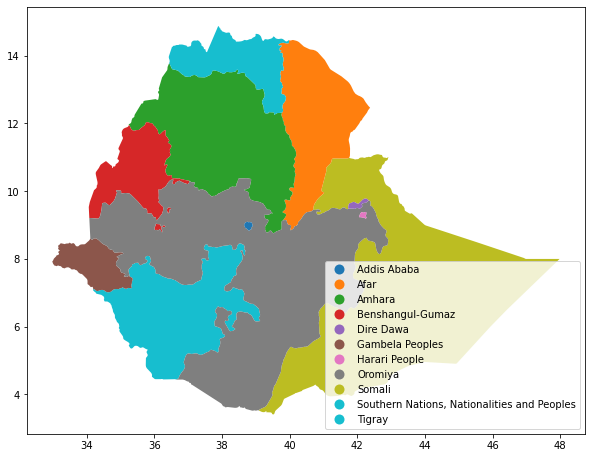

In [4]:
# Load in shapefile from natural earth
ne_shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
ne_gdf = gpd.read_file(ne_shapefile)

if len(regions_of_interest) == 0:
    # Select entire country (all regions):
    condition = ne_gdf["adm1_code"].str.startswith(country_code)
    boundary = ne_gdf[condition].copy()
    print("Entire country found!")

else:
    # Check regions
    available_regions = ne_gdf[ne_gdf["adm1_code"].str.startswith(country_code)]["name"].tolist()
    regions_not_found = [region for region in regions_of_interest if region not in available_regions]

    if len(regions_not_found) > 0:
        condition = ne_gdf["adm1_code"].str.startswith(country_code)
        boundary = None
        print(f"WARNING: {regions_not_found} was not found. Please select regions only seen in below plot.")
    else:
        condition = ne_gdf["name"].isin(regions_of_interest)
        boundary = ne_gdf[condition].copy()
        print("All regions found!")

ne_gdf[condition].plot(
    column="name", 
    legend=True, 
    legend_kwds={'loc': 'lower right'}, 
    figsize=(10,10)
);

## 2. Convert crop prediction maps to binarized masks

### Load the predicted maps for each year

In [5]:
preds_path_y1 = '/gpfs/data1/cmongp1/hkerner/fewsnet/preds/croptour_v2/bure-jimma_v1_2019-02-01_2020-02-01_epsg32637.tif'
preds_path_y2 = '/gpfs/data1/cmongp1/hkerner/fewsnet/preds/croptour_v2/bure-jimma_v1_2020-02-01_2021-02-01_epsg32637.tif'
target_crs = 'epsg:32637'

In [6]:
# Loads the raster from the .tif file as a numpy array
# Returns a masked array where the nodata values are masked
def load_raster(path, target_crs='epsg:4326', clip_coords=None):
    with rio.open(path) as src:
        if src.meta['crs'] == 'epsg:4326':
            print('''WARNING: The map CRS is EPSG:4326. This means the map unit is degrees 
                  and the pixel-wise areas will not be in meters. You need to reproject the map
                  to the projection defined for the map's primary UTM zone (e.g., EPSG:32652).''')
        else:
            print('Map CRS is %s. Loading map into memory.' % src.crs)
            print(src.meta)
            if clip_coords:
                raster, out_transform = mask(src, shapes=clip_coords, crop=True)
                raster = raster[0]
                # Update the metadata
                out_meta = src.meta.copy()
                out_meta.update({"driver": "GTiff",
                                 "height": raster.shape[0],
                                 "width": raster.shape[1],
                                 "transform": out_transform,
                                 "crs": src.meta['crs']}
                               )
                return np.ma.masked_equal(raster, src.meta['nodata']), out_meta
            else:
                raster = src.read(1)
                return np.ma.masked_equal(raster, src.meta['nodata']), src.meta

In [8]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

# Optionally specify bounding box boundaries to clip to
# Note that these boundaries must be in the same CRS as the raster
# You can get this from bboxfinder, e.g.: http://bboxfinder.com/#10.277000,36.864900,10.835100,37.191000
minx, miny, maxx, maxy = 249141.6217,840652.3433,272783.1953,855138.2342
bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=target_crs)
coords = getFeatures(geo)

In [9]:
preds_y1, preds_y1_meta = load_raster(preds_path_y1, target_crs, coords)

Map CRS is EPSG:32637. Loading map into memory.
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 255.0, 'width': 44371, 'height': 44670, 'count': 1, 'crs': CRS.from_epsg(32637), 'transform': Affine(10.0, 0.0, -52943.83854328655,
       0.0, -10.0, 1220556.6427310891)}


In [10]:
preds_y2, preds_y2_meta = load_raster(preds_path_y2, target_crs, coords)

Map CRS is EPSG:32637. Loading map into memory.
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 255.0, 'width': 44371, 'height': 44670, 'count': 1, 'crs': CRS.from_epsg(32637), 'transform': Affine(10.0, 0.0, -52943.83854328655,
       0.0, -10.0, 1220556.6427310891)}


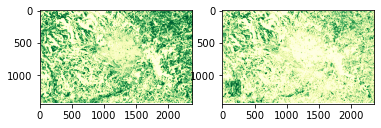

In [11]:
# Plot the map to make sure it looks as expected
# This may take a while depending on the size of the map,
# so you may choose not to run this every time.
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(preds_y1, cmap='YlGn')
ax[1].imshow(preds_y2, cmap='YlGn', vmin=0, vmax=1)

### Binarize the predicted maps to create crop masks

- Convert the maps to 1 where p >= 0.5 and 0 where p < 0.5. 
- Leave no-data values (255 if using the example above) as is - this should be automatically handled since the rasters were loaded as masked arrays.
- Cast the type to uint8 since they should now have values of 0, 1, or 255/masked.

In [12]:
def binarize(raster, nodata=255, threshold=0.5):
    raster[raster < threshold] = 0
    raster[((raster >= threshold) & (raster != nodata))] = 1
    return raster.astype(np.uint8)

In [13]:
cropmask_y1 = binarize(preds_y1)

In [14]:
cropmask_y2 = binarize(preds_y2)

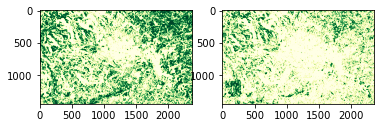

In [15]:
# Plot the map to make sure it looks as expected
# This may take a while depending on the size of the map,
# so you may choose not to run this every time.
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(cropmask_y1, cmap='YlGn', vmin=0, vmax=1)
ax[1].imshow(cropmask_y2, cmap='YlGn', vmin=0, vmax=1)

## 3. Create 4-class change map based on crop masks from two years

The change map is calculated from the annual crop masks as follows:

|  y1 | y1 * 2 |  y2 | y1 * 2 + y2 | interpretation |
| :---: | :---: | :---: | :---: | :---: |
| 0 | 0 | 0 | 0 | stable not planted |
| 0 | 0 | 1 | 1 | planted gain |
| 1 | 2 | 0 | 2 | planted loss |
| 1 | 2 | 1 | 3 | stable planted |

In [16]:
change_map = cropmask_y1*2 + cropmask_y2

In [17]:
# Check that the unique values are 0, 1, 2, 3, 255/nodata
np.unique(change_map.flatten())

masked_array(data=[0, 1, 2, 3],
             mask=[False, False, False, False],
       fill_value=255,
            dtype=uint8)

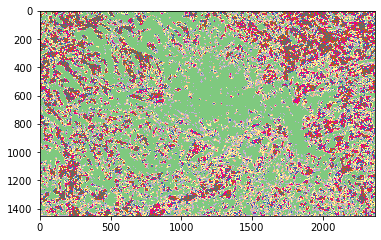

In [18]:
# Visualize the change map
# green = 0 = stable not planted
# gray = 3 = stable planted
plt.imshow(change_map, cmap='Accent')

In [19]:
# Write the change map to a tif file
change_tif_path = '/gpfs/data1/cmongp1/hkerner/fewsnet/preds/croptour_v2/bure_change_2019-2020.tif'
change_meta = preds_y1_meta.copy()
change_meta['dtype'] = change_map.dtype

with rio.open(change_tif_path, "w", **change_meta) as dest:
    dest.write(np.expand_dims(change_map, 0))

### Calculate the mapped area for each class

In [20]:
# Get the pixel size from the transform in the raster metadata that was printed earlier
pixel_size = 10

In [21]:
# Function to calculate mapped area in pixels or ha
def mapped_area(pred_map, unit='pixels', px_size=10):
    stable_np = np.where(pred_map.flatten() == 0)[0]
    p_gain = np.where(pred_map.flatten() == 1)[0]
    p_loss = np.where(pred_map.flatten() == 2)[0]
    stable_p = np.where(pred_map.flatten() == 3)[0]
    total = pred_map.flatten().shape[0]
    # Make sure nodata values are not being counted
    assert total == np.where(pred_map.flatten() < 255)[0].shape[0]
    # Multiply pixels by area per pixel and convert m to hectares
    if unit == 'ha':
        stable_np_area = stable_np.shape[0] * (px_size*px_size) / 100000
        p_gain_area = p_gain.shape[0] * (px_size*px_size) / 100000
        p_loss_area = p_loss.shape[0] * (px_size*px_size) / 100000
        stable_p_area = stable_p.shape[0] * (px_size*px_size) / 100000
    # Get the total number of pixels for each class
    elif unit == 'pixels':
        stable_np_area = int(stable_np.shape[0])
        p_gain_area = int(p_gain.shape[0])
        p_loss_area = int(p_loss.shape[0])
        stable_p_area = int(stable_p.shape[0])
    # Get the fraction of total pixels for each class
    elif unit == 'fraction':
        stable_np_area = int(stable_np.shape[0]) / total
        p_gain_area = int(p_gain.shape[0]) / total
        p_loss_area = int(p_loss.shape[0]) / total
        stable_p_area = int(stable_p.shape[0]) / total
        assert sum([stable_np_area, p_gain_area, p_loss_area, stable_p_area]) == 1
    return stable_np_area, p_gain_area, p_loss_area, stable_p_area

In [22]:
stable_np_frac, p_gain_frac, p_loss_frac, stable_p_frac = mapped_area(change_map, unit='fraction')
print('Stable NP area [fraction] = %f' % stable_np_frac)
print('P gain area [fraction] = %f' % p_gain_frac)
print('P loss area [fraction] = %f' % p_loss_frac)
print('Stable P area [fraction] = %f' % stable_p_frac)

Stable NP area [fraction] = 0.613536
P gain area [fraction] = 0.020652
P loss area [fraction] = 0.193494
Stable P area [fraction] = 0.172318


In [23]:
stable_np_px, p_gain_px, p_loss_px, stable_p_px = mapped_area(change_map, unit='pixels')
print('Stable NP area [pixels] = %f' % stable_np_px)
print('P gain area [pixels] = %f' % p_gain_px)
print('P loss area [pixels] = %f' % p_loss_px)
print('Stable P area [pixels] = %f' % stable_p_px)

Stable NP area [pixels] = 2103970.000000
P gain area [pixels] = 70820.000000
P loss area [pixels] = 663539.000000
Stable P area [pixels] = 590921.000000


In [24]:
stable_np_ha, p_gain_ha, p_loss_ha, stable_p_ha = mapped_area(change_map, unit='ha')
print('Stable NP area [ha] = %f' % stable_np_ha)
print('P gain area [ha] = %f' % p_gain_ha)
print('P loss area [ha] = %f' % p_loss_ha)
print('Stable P area [ha] = %f' % stable_p_ha)

Stable NP area [ha] = 2103.970000
P gain area [ha] = 70.820000
P loss area [ha] = 663.539000
Stable P area [ha] = 590.921000


## 4. Create random stratified reference sample from change map strata following best practices

First we need to determine the number of total samples we want to label for our reference dataset.

We use the method identified by Olofsson et al. in [*Good practices for estimating area and assessing accuracy of land change*](https://www.sciencedirect.com/science/article/pii/S0034425714000704) (eq 13) to determine sample size:

n ≈ ( Σ(W<sub>i</sub>S<sub>i</sub>) / S(Ô) )<sup>2</sup>

| Where         |                                                      |
|---------------|------------------------------------------------------|
| W<sub>i</sub> | Mapped proportion of class i                         |
| S<sub>i</sub> | Standard deviation √(U<sub>i</sub>(1-U<sub>i</sub>)) |
| U<sub>i</sub> | Expected user's accuracy for class i                 |
| S(Ô)          | Standard error                                       |
| n             | Sample size                                          |

When two maps with associated error rates are compared as in our change maps, the error multiplies. So to come up with a reasonable estimate U<sub>i</sub>, multiply the user's accuracy (precision) from each of the annual maps. For example, if precision for the Y1 map is 0.84 and Y2 is 0.75, then U<sub>i</sub> = 0.84 * 0.75 = 0.63.

If we use 0.63 for the user accuracy of all classes and choose a standard error of 0.02, then since Σ(W<sub>i</sub>) = 1, 

n ≈ ((W<sub>0</sub>(0.48) + W<sub>1</sub>(0.48) + W<sub>2</sub>(0.48) + W<sub>3</sub>(0.48)) / 0.02)<sup>2</sup> = 583

In [25]:
u = 0.63
stderr = 0.02

s = np.sqrt(u * (1-u))
n = np.round(((stable_np_frac*s + p_gain_frac*s + p_loss_frac*s + stable_p_frac*s) / stderr)**2)

print('Standard deviation: {:.2f}'.format(s))
print('Num samples: {}'.format(int(n)))

Standard deviation: 0.48
Num samples: 583


We will use a stratified random sample, meaning we will sample some number of points randomly within each of our map strata (the four change classes). Refer to Section 5.1.2 in Olofsson et al. for in depth discussion on different sample allocation methods. We will use the Alloc1 strategy which allocates 100 samples to each of the change classes and then proportionally allocates the remaining samples. 

In [26]:
n_pgain = 100
n_ploss = 100
n_stablenp = int((n - n_pgain - n_ploss) * (stable_np_frac / (stable_np_frac + stable_p_frac)))
n_stablep = int(n - n_pgain - n_ploss - n_stablenp)
assert n_pgain + n_ploss + n_stablenp + n_stablep == n

In [27]:
print('Sample allocation:')
print('P gain: {}'.format(n_pgain))
print('P loss: {}'.format(n_ploss))
print('Stable NP: {}'.format(n_stablenp))
print('Stable P: {}'.format(n_stablep))

Sample allocation:
P gain: 100
P loss: 100
Stable NP: 299
Stable P: 84


Now we can randomly draw sample locations using this allocation from each of the map strata.

In [28]:
def random_inds(raster, strata, n):
    inds = np.where(raster == strata)
    rand_inds = np.random.choice(np.arange(inds[0].shape[0]), size=n, replace=False)
    rand_px = inds[0][rand_inds]
    rand_py = inds[1][rand_inds]
    return rand_px, rand_py

In [29]:
df_stablenp = pd.DataFrame([], columns=['px', 'py', 'pred_class'])
df_stablenp['px'], df_stablenp['py'] = random_inds(change_map, 0, n_stablenp)
df_stablenp['pred_class'] = 0

In [30]:
df_pgain = pd.DataFrame([], columns=['px', 'py', 'pred_class'])
df_pgain['px'], df_pgain['py'] = random_inds(change_map, 1, n_pgain)
df_pgain['pred_class'] = 1

In [31]:
df_ploss = pd.DataFrame([], columns=['px', 'py', 'pred_class'])
df_ploss['px'], df_ploss['py'] = random_inds(change_map, 2, n_ploss)
df_ploss['pred_class'] = 2

In [32]:
df_stablep = pd.DataFrame([], columns=['px', 'py', 'pred_class'])
df_stablep['px'], df_stablep['py'] = random_inds(change_map, 3, n_stablep)
df_stablep['pred_class'] = 3

In [33]:
df_combined = pd.concat([df_stablenp, df_pgain, df_ploss, df_stablep]).reset_index(drop=True)

<AxesSubplot:xlabel='pred_class'>

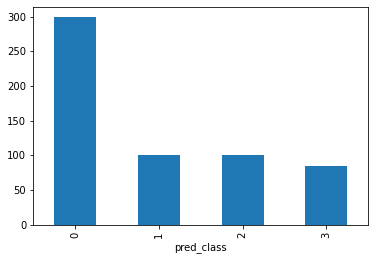

In [34]:
# Plot the number of samples in each strata to confirm
df_combined.groupby('pred_class').count()['px'].plot(kind='bar')

In [35]:
# Convert the pixel locations to geographic locations
with rio.open(change_tif_path) as src:
    for r, row in df_combined.iterrows():
        # translate to geographic coordinates
        lx, ly = src.xy(row['px'], row['py'])
        df_combined.loc[r, 'lx'] = lx
        df_combined.loc[r, 'ly'] = ly

In [36]:
# Shuffle the dataframe so the classes are randomized in CEO
df_combined = df_combined.sample(frac=1).reset_index(drop=True)

In [37]:
df_combined.head()

,px,py,pred_class,lx,ly
0,994,1665,2,265791.161457,845201.642731
1,1382,1479,0,263931.161457,841321.642731
2,268,1588,2,265021.161457,852461.642731
3,978,1572,0,264861.161457,845361.642731
4,650,1587,0,265011.161457,848641.642731


In [38]:
# Convert the pandas dataframe to a geopandas dataframe
gdf = gpd.GeoDataFrame(df_combined, geometry=gpd.points_from_xy(df_combined.lx, df_combined.ly))

In [39]:
gdf.head()

,px,py,pred_class,lx,ly,geometry
0,994,1665,2,265791.161457,845201.642731,POINT (265791.161 845201.643)
1,1382,1479,0,263931.161457,841321.642731,POINT (263931.161 841321.643)
2,268,1588,2,265021.161457,852461.642731,POINT (265021.161 852461.643)
3,978,1572,0,264861.161457,845361.642731,POINT (264861.161 845361.643)
4,650,1587,0,265011.161457,848641.642731,POINT (265011.161 848641.643)


In [40]:
gdf.crs = target_crs

In [47]:
# Save the labels in the local CRS first
ref_sample_path_local = '/gpfs/data1/cmongp1/hkerner/fewsnet/preds/croptour_v2/ref_samples/change_2019-2020_jimma_strat_ref_samples_epsg32637.shp'
gdf.to_file(ref_sample_path_local)

We need to label these reference samples in Collect Earth Online (CEO). We need to format them in a certain way to be able to upload them to CEO.

In [42]:
# Convert to 4326 for CEO
gdf_4326 = gdf.to_crs('EPSG:4326')

In [43]:
gdf_4326['PLOTID'] = gdf_4326.index

In [44]:
gdf_4326['SAMPLEID'] = gdf_4326.index

In [45]:
gdf_4326.head()

,px,py,pred_class,lx,ly,geometry,PLOTID,SAMPLEID
0,994,1665,2,265791.161457,845201.642731,POINT (36.87696 7.64113),0,0
1,1382,1479,0,263931.161457,841321.642731,POINT (36.86029 7.60597),1,1
2,268,1588,2,265021.161457,852461.642731,POINT (36.86966 7.70672),2,2
3,978,1572,0,264861.161457,845361.642731,POINT (36.86853 7.64253),3,3
4,650,1587,0,265011.161457,848641.642731,POINT (36.86974 7.67219),4,4


In [48]:
# Save the labels in the CEO format
ref_sample_path_ceo = '/gpfs/data1/cmongp1/hkerner/fewsnet/preds/croptour_v2/ref_samples/change_2019-2020_jimma_strat_ref_samples_ceo.shp'
gdf_4326[['geometry', 'PLOTID', 'SAMPLEID']].to_file(ref_sample_path_ceo, index=False)

### Label the reference samples in CEO

This step is done in Collect Earth Online. First you need to create a labeling project with the shapefile we just created (two copies for consensus). Once all of the points in both sets have been labeled, come back to Step 7.

See the instructions for labeling planted area change points [here](https://docs.google.com/presentation/d/18bJHMX5M1jIR9NBWIdYeJyo3tG4CL3dNO5vvxOpz5-4/edit#slide=id.p).

TODO edit the rest of this notebook after the samples are labeled.

### Load the labeled reference samples

There should be two sets of labels for the reference sample. We compare the labels from each set to filter out labels for which the labelers did not agree and thus we can't be confident about the true label.

In [ ]:
ceo_set1 = pd.read_csv(ceo_set1_path)
ceo_set1.head()

In [ ]:
ceo_set2 = pd.read_csv(ceo_set2_path)
ceo_set2.head()

In [ ]:
# Make sure the question and thus column name is correct for the project you are working on
ceo_agree = ceo_set1[ceo_set1['Does this point lie on active cropland?'] == 
                         ceo_set2['Does this point lie on active cropland?']]

print('Number of samples that are in agreement: %d out of %d (%.2f%%)' % 
          (ceo_agree.shape[0], ceo_set1.shape[0], ceo_agree.shape[0]/ceo_set1.shape[0]*100))

In [ ]:
# Convert the pandas dataframe to a geodataframe
ceo_agree_geom = gpd.GeoDataFrame(ceo_agree, geometry=gpd.points_from_xy(ceo_agree.lon, ceo_agree.lat), crs='EPSG:4326')

In [ ]:
# The labeling platform CEO requires points to be in EPSG:4326. 
# Reproject to the same crs as the map.
ceo_agree_geom = ceo_agree_geom.to_crs(src.crs)

In [ ]:
# Plot them to make sure they look as expected
ceo_agree_geom.plot();

### Get the mapped class for each of the reference samples

In [ ]:
for r, row in ceo_agree_geom.iterrows():
    # transform lon, lat to pixel coordinates
    lon, lat = row['geometry'].y, row['geometry'].x
    px, py = src.index(lat, lon)
    ceo_agree_geom.loc[r,'Mapped class'] = crop_map[px, py]

In [ ]:
ceo_agree_geom.head()

In [ ]:
# Make sure none of them are nodata
ceo_agree[ceo_agree_geom['Mapped class'] == 3]

## 5. Compute the confusion matrix between the labeled reference sample and the change map

In [ ]:
# Convert the CEO string label to an integer label
ceo_agree_geom.loc[ceo_agree_geom['Does this point lie on active cropland?'] == 'Crop', 'Reference label'] = 1
ceo_agree_geom.loc[ceo_agree_geom['Does this point lie on active cropland?'] == 'Non-crop', 'Reference label'] = 0
ceo_agree_geom['Reference label'] = ceo_agree_geom['Reference label'].astype(np.uint8)
ceo_agree_geom.head()

In [ ]:
# Compute confusion matrix
y_true = np.array(ceo_agree_geom['Reference label']).astype(np.uint8)
y_pred = np.array(ceo_agree_geom['Mapped class']).astype(np.uint8)
confusion_matrix(y_true, y_pred)

In [ ]:
# Extract and print confusion matrix values with element descriptions
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('True negatives: %d' % tn)
print('False positives: %d' % fp)
print('False negatives: %d' % fn)
print('True positives: %d' % tp)

## 6. Calculate the change class areas and accuracy estimates based on Olofsson et al., 2014

$W_h$ is the proportion of mapped area for each class 

In [ ]:
wh_crop = crop_area_px / tot_area_px
print('Wh_crop = %f' % wh_crop)

wh_noncrop = noncrop_area_px / tot_area_px
print('Wh_noncrop = %f' % wh_noncrop)

Compute the fraction of the proportional area of each class that was mapped as each category in the confusion matrix

In [ ]:
tp_area = tp / (tp + fp) * wh_crop
fp_area = fp / (tp + fp) * wh_crop
fn_area = fn / (fn + tn) * wh_noncrop
tn_area = tn / (fn + tn) * wh_noncrop

print('%f \t %f \n %f \t %f' % (tp_area, fp_area, fn_area, tn_area))

$U_i$ is the user's accuracy (i.e., precision) for each mapped class. We calculate it here in terms of proportion of area computed in the last cell.

In [ ]:
u_crop = tp_area / (tp_area + fp_area)
print('U_crop = %f' % u_crop)

u_noncrop = tn_area / (tn_area + fn_area)
print('U_noncrop = %f' % u_noncrop)

$V(U_i)$ is the estimated variance of user accuracy for each mapped class.

In [ ]:
v_u_crop = u_crop * (1-u_crop) / (tp + fp)
print('V(U)_crop = %f' % v_u_crop)

v_u_noncrop = u_noncrop * (1-u_noncrop) / (fn + tn)
print('V(U)_noncrop = %f' % v_u_noncrop)

$S(U_i)$ is the estimated standard error of user accuracy for each mapped class.

In [ ]:
s_u_crop = np.sqrt(v_u_crop)
print('S(U)_crop = %f' % s_u_crop)

s_u_noncrop = np.sqrt(v_u_noncrop)
print('S(U)_noncrop = %f' % s_u_noncrop)

Get the 95% confidence interval for User's accuracy

In [ ]:
u_crop_err = s_u_crop * 1.96
print('95%% CI of User accuracy for crop = %f' % u_crop_err)

u_noncrop_err = s_u_noncrop * 1.96
print('95%% CI of User accuracy for noncrop = %f' % u_noncrop_err)

$P$ is the producer's accuracy (i.e., recall). We calculate it here in terms of proportion of area.

In [ ]:
p_crop = tp_area / (tp_area + fn_area)
print('P_crop = %f' % p_crop)

p_noncrop = tn_area / (tn_area + fp_area)
print('P_noncrop = %f' % p_noncrop)

$N_j$ is the estimated marginal total number of pixels of each reference class $j$

In [ ]:
n_j_crop = (crop_area_px * tp) / (tp + fp) + (noncrop_area_px * fn) / (fn + tn)
print('N_j_crop = %f' % n_j_crop)

n_j_noncrop = (crop_area_px * fp) / (tp + fp) + (noncrop_area_px * tn) / (fn + tn)
print('N_j_crop = %f' % n_j_noncrop)

In [ ]:
expr1_crop = crop_area_px**2 * (1-p_crop)**2 * u_crop * (1-u_crop) / (tp + fp - 1)
print('expr1 crop = %f' % expr1_crop)

expr1_noncrop = noncrop_area_px**2 * (1-p_noncrop)**2 * u_noncrop * (1-u_noncrop) / (fp + tn - 1)
print('expr1 noncrop = %f' % expr1_noncrop)

In [ ]:
# Warning: depending on the size of your map, you may get an overflow warning here, e.g.
# RuntimeWarning: overflow encountered in long_scalars
# Need to figure out if we can correct this...
expr2_crop = p_crop**2 * (noncrop_area_px**2 * fn / (fn + tn) * (1 - fn / (fn + tn)) / (fn + tn - 1))
print('expr2 crop = %f' % expr2_crop)

expr2_noncrop = p_crop**2 * (crop_area_px**2 * fp / (fp + tp) * (1 - fp / (fp + tp)) / (fp + tp - 1))
print('expr2 noncrop = %f' % expr2_noncrop)

$V(P_i)$ is the estimated variance of producer's accuracy for each mapped class.

In [ ]:
v_p_crop = (1 / n_j_crop**2) * (expr1_crop + expr2_crop)
print('V(P) crop = %f' % v_p_crop)

v_p_noncrop = (1 / n_j_noncrop**2) * (expr1_noncrop + expr2_noncrop)
print('V(P) noncrop = %f' % v_p_noncrop)

$S(P_i)$ is the estimated standard error of producer accuracy for each mapped class.

In [ ]:
# Warning: depending on the size of your map, you may get an overflow warning here, e.g.
# RuntimeWarning: overflow encountered in long_scalars
# Need to figure out if we can correct this...
s_p_crop = np.sqrt(v_p_crop)
print('S(P) crop = %f' % s_p_crop)

s_p_noncrop = np.sqrt(v_p_noncrop)
print('S(P) noncrop = %f' % s_p_noncrop)

Get the 95% confidence interval for Producer's accuracy

In [ ]:
p_crop_err = s_p_crop * 1.96
print('95%% CI of Producer accuracy for crop = %f' % p_crop_err)

p_noncrop_err = s_p_noncrop * 1.96
print('95%% CI of Producer accuracy for noncrop = %f' % p_noncrop_err)

$O$ is the overall accuracy. We calculate it here in terms of proportion of area.

In [ ]:
acc = tp_area + tn_area
print('Overall accuracy = %f' % acc)

$V(O)$ is the estimated variance of the overall accuracy

In [ ]:
v_acc = wh_crop**2 * u_crop * (1-u_crop) / (tp + fp - 1) + \
        wh_noncrop**2 * u_noncrop * (1-u_noncrop) / (fn + tn - 1)
print('V(O) = %f' % v_acc)

$S(O)$ is the estimated standard error of the overall accuracy

In [ ]:
s_acc = np.sqrt(v_acc)
print('S(O) = %f' % s_acc)

Get the 95% confidence interval for overall accuracy

In [ ]:
acc_err = s_acc * 1.96
print('95%% CI of overall accuracy = %f' % acc_err)

$A_{pixels}$ is the adjusted map area in units of pixels

In [ ]:
a_pixels_crop = tot_area_px * (tp_area + fn_area)
print('A^[pixels] crop = %f' % a_pixels_crop)

a_pixels_noncrop = tot_area_px * (tn_area + fp_area)
print('A^[pixels] noncrop = %f' % a_pixels_noncrop)

$A_{ha}$ is the adjusted map area in units of hectares

In [ ]:
a_ha_crop = a_pixels_crop * (pixel_size*pixel_size) / (100*100)
print('A^[ha] crop = %f' % a_ha_crop)

a_ha_noncrop = a_pixels_noncrop * (pixel_size*pixel_size) / (100*100)
print('A^[ha] noncrop = %f' % a_ha_noncrop)

The following equations are used to estimate the standard error for the area. They are based on the calculations in Olofsson et al., 2014.

In [ ]:
S_pk_crop = np.sqrt((wh_crop * tp_area - tp_area**2) / (tp + fp - 1) + \
                     (wh_noncrop * fn_area - fn_area**2) / (fn + tn - 1)) * tot_area_px
print('S_pk_crop = %f' % S_pk_crop)

S_pk_noncrop = np.sqrt((wh_crop * fp_area - fp_area**2) / (tp + fp - 1) + \
                        (wh_noncrop * tn_area - tn_area**2) / (fn + tn - 1)) * tot_area_px
print('S_pk_noncrop = %f' % S_pk_noncrop)

Multiply $S(p_k)$ by 1.96 to get the margin of error for the 95% confidence interval

In [ ]:
a_pixels_crop_err = S_pk_crop * 1.96
print('Crop area standard error 95%% confidence interval [pixels] = %f' % a_pixels_crop_err)

a_pixels_noncrop_err = S_pk_noncrop * 1.96
print('Non-crop area standard error 95%% confidence interval [pixels] = %f' % a_pixels_noncrop_err)

In [ ]:
a_ha_crop_err = a_pixels_crop_err * (pixel_size**2) / (100**2)
print('Crop area standard error 95%% confidence interval [ha] = %f' % a_ha_crop_err)

a_ha_noncrop_err = a_pixels_noncrop_err * (pixel_size**2) / (100**2)
print('Non-crop area standard error 95%% confidence interval [ha] = %f' % a_ha_noncrop_err)

Summary of the final estimates of accuracy and area with standard error at 95% confidence intervals:

In [ ]:
summary = pd.DataFrame([[a_ha_crop, a_ha_noncrop],
                        [a_ha_crop_err, a_ha_noncrop_err],
                        [u_crop, u_noncrop],
                        [u_crop_err, u_noncrop_err],
                        [p_crop, p_noncrop],
                        [p_crop_err, p_noncrop_err],
                        [acc, acc],
                        [acc_err, acc_err]
                       ],
                       index=pd.Index(['Estimated area [ha]', '95% CI of area [ha]', 'User accuracy',
                                       '95% CI of user acc', 'Producer accuracy', '95% CI of prod acc',
                                       'Overall accuracy', '95% CI of overall acc']),
                       columns=['Crop', 'Non-crop'])

summary.round(2)